In [1]:
import numpy as np
import pandas as pd
import xgboost
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import warnings
from copy import deepcopy
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_palette("cubehelix", 8)#"deep")
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from problem_creator import gen_regression_symbolic, gen_classification_symbolic

## Utils

In [2]:
def train_and_evaluate_model(model, x, y, score_metric=mse):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    score = score_metric(preds, y_test)
    return model, score


def calculate_tree_shap_coeffs(model, x):
    x = x.astype(float)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x)
    shap_coeffs = np.absolute(shap_values).mean(axis=0)
    return shap_coeffs, explainer, shap_values

def test_data2(data_points=1000, number=10):
    x = []
    for i in range(number):
        #x.append(np.random.normal(0, 10, data_points))
        x.append(np.random.uniform(0,1,data_points))
    x = np.array(x).T
    fi = deepcopy(x)
    for i in range(number):
        fi[:,i] = fi[:,i]*i+1
    y = fi.sum(1)
    return x, y, fi


def test_data2(data_points=1000, features=10):
    x = []
    for i in range(features):
        x.append(np.random.choice([-1,1], data_points))
    x = np.array(x).T
    fi = deepcopy(x)
    for i in range(features):
        fi[:,i] = fi[:,i]*i+1
    y = fi.sum(1)
    return x, y, fi

def test_data3(data_points=1000, features=5):
    x = []
    for i in range(features):
        x.append(np.random.uniform(0,1,data_points))
    x = np.array(x).T
    fi = deepcopy(x)
    for i in range(features):
        fi[:,i] = fi[:,i]*(i+1)*2
    y = fi.sum(1)
    return x, y, fi


def make_string(coeffs):
    s = ''
    for i,c in enumerate(coeffs):
        s+= 'x{}*{}+'.format(i,c)
    return s[:-1]

def make_data(coeffs=[1,2,3,4,5,6,7,8,9,10],noise=0,data_points=100,kind='reg'):
    formular = make_string(coeffs)
    np.random.seed(1)
    if kind == 'reg':
        data = gen_regression_symbolic(m=formular, n_samples=data_points, noise=noise)
    if kind == 'clas':
        data = gen_classification_symbolic(m=formular, n_samples=data_points, flip_y=noice) 
    X = data[:,:-1]
    y = data[:,-1]
    fi = deepcopy(X)
    for i in range(len(coeffs)):
        fi[:,i] = fi[:,i]*coeffs[i]
    return X,y, fi

def plot_colors():
    plt.bar(range(1,11),range(1,11),color=['C{}'.format(i) for i in range(10)])
    
def compare_fi_methods(datapoints, data=test_data3, num_feature=5):

    x, y, fi = data(data_points=datapoints, features=num_feature)
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    model = xgboost.XGBRegressor(gbtree='gbtree', objective='reg:squarederror')
    fitted_model, score_before = train_and_evaluate_model(model, x, y, mse)
    types_dict = {}
    for method in ['gain','weight', 'cover', 'total_cover','total_gain']:
        f_dict = fitted_model.get_booster().get_score(importance_type=method)
        types_dict[method] = f_dict

    shap_coeffs, explainer, shap_values = calculate_tree_shap_coeffs(fitted_model, x)

    types_df = pd.DataFrame(types_dict)
    if len(types_df) < x.shape[1]:
        for missing_feature in np.setdiff1d(['f{}'.format(i) for i in range(x.shape[1])], types_df.index):
            temp = pd.DataFrame({missing_feature:[0,0,0,0,0]}).T
            temp.columns = ['cover','gain','weight', 'total_cover','total_gain']
            types_df = temp.append(types_df)
    types_df = types_df.div(types_df.sum())
    shaps = deepcopy(np.abs(shap_values).sum(0))
    types_df['SHAP'] = np.array(shaps)/shaps.sum()
    types_df['True'] = np.array([i for i in range(1,x.shape[1]+1)])/np.sum([i for i in range(1,x.shape[1]+1)])
    return types_df, score_before

## Compare Number of Features

In [6]:
num_features = [5,10,50,100]
diffs  = {}
stds = {}
mean_scores = []
for num in num_features:
    tries = []
    print(num)
    scores = []
    for i in range(20):
        types_df, score = compare_fi_methods(num*100,test_data3, num)
        diff_df = types_df[['cover','gain','weight', 'total_cover','total_gain','SHAP']].sub(types_df['True'],axis='index').abs()
        tries.append(diff_df.sum())
        scores.append(score)
    mean_score_num = np.round(np.mean(scores),1)
    tries = pd.concat(tries,axis=1)
    diffs[num] = tries.mean(1)
    stds[num] = tries.std(1)
    mean_scores.append(mean_score_num)

diffs = pd.DataFrame(diffs)
stds = pd.DataFrame(stds)

new_columns = ['{}, {}'.format(column, mean_scores[i]) for i, column in enumerate(diffs.columns)]
diffs.columns = new_columns
stds.columns = new_columns

5
10
50
100


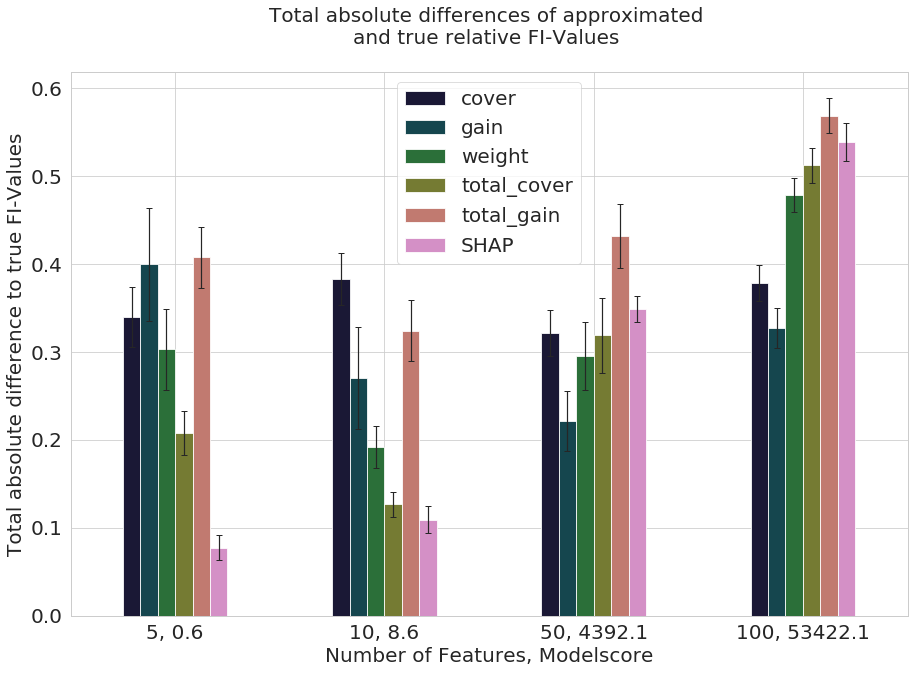

In [7]:
diffs.T.plot.bar(figsize=(15,10), yerr=stds.T, capsize=3)
plt.title('Total absolute differences of approximated \nand true relative FI-Values \n',fontsize=20)
plt.xticks(rotation=0)
plt.xlabel('Number of Features, Modelscore',fontsize=20)
plt.ylabel('Total absolute difference to true FI-Values',fontsize=20)
plt.legend(fontsize=20)
plt.tick_params(labelsize=20)

## Compare Datasetsize

In [4]:
datapoints = [10,50,100,500,1000,5000,10000]
diffs  = {}
stds = {}
mean_scores = []
for num in datapoints:
    tries = []
    print(num)
    scores = []
    for i in range(20):
        types_df, score = compare_fi_methods(num, data=test_data3, num_feature=10)
        diff_df = types_df[['cover','gain','weight', 'total_cover','total_gain','SHAP']].sub(types_df['True'],axis='index').abs()
        tries.append(diff_df.sum())
        scores.append(score)
    mean_score_num = np.round(np.mean(scores),1)
    tries = pd.concat(tries,axis=1)
    diffs[num] = tries.mean(1)
    stds[num] = tries.std(1)
    mean_scores.append(mean_score_num)

diffs = pd.DataFrame(diffs)
stds = pd.DataFrame(stds)

new_columns = ['{}, {}'.format(column, mean_scores[i]) for i, column in enumerate(diffs.columns)]
diffs.columns = new_columns
stds.columns = new_columns

10
50
100
500
1000
5000
10000


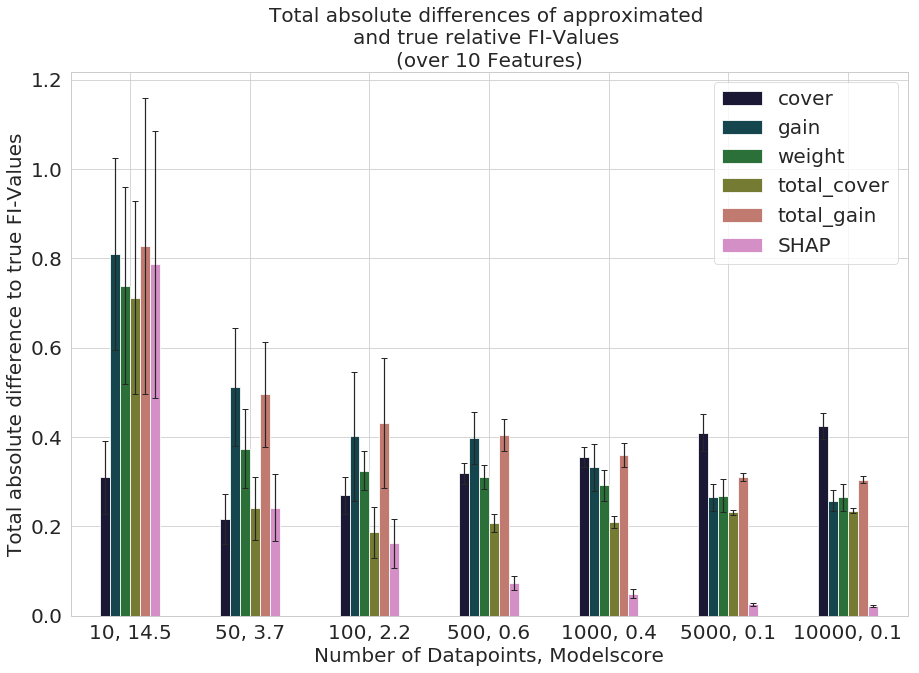

In [5]:
diffs.T.plot.bar(figsize=(15,10), yerr=stds.T, capsize=3)
plt.title('Total absolute differences of approximated \nand true relative FI-Values \n(over 10 Features)',fontsize=20)
plt.xticks(rotation=0)
plt.xlabel('Number of Datapoints, Modelscore',fontsize=20)
plt.ylabel('Total absolute difference to true FI-Values',fontsize=20)
plt.legend(fontsize=20)
plt.tick_params(labelsize=20)

## Single Test

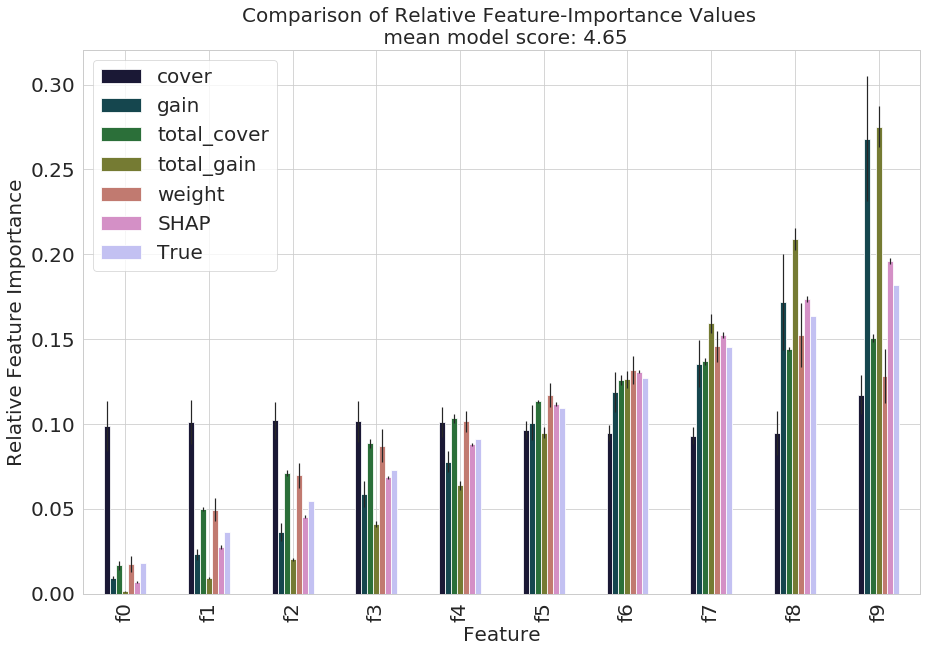

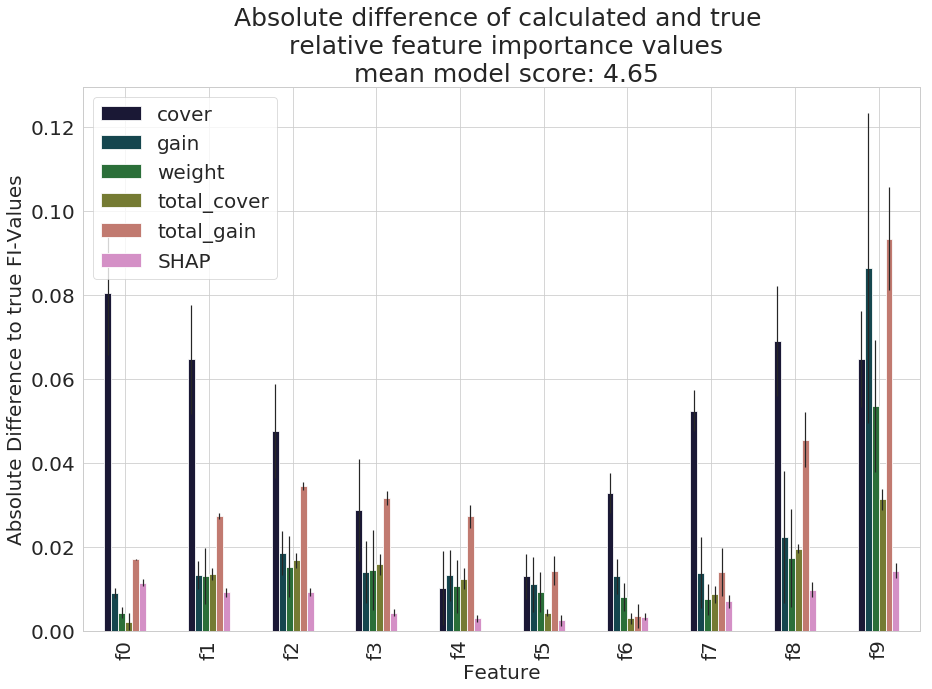

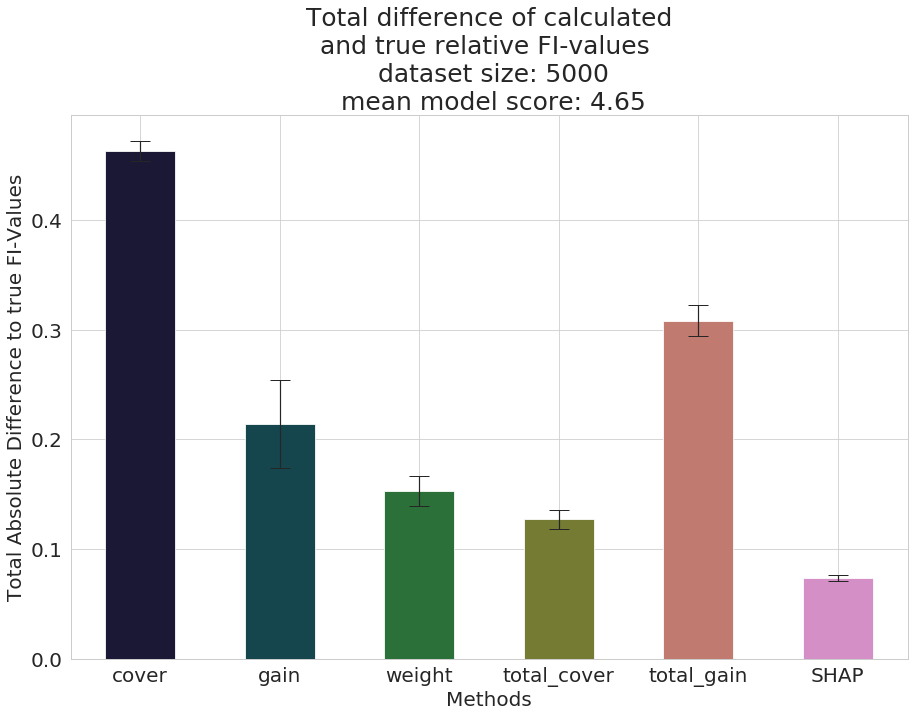

In [5]:
datapoints = 5000
results = []
diffs = []
scores = []
for i in range(5):
    types_df, score = compare_fi_methods(datapoints,test_data3,10)
    scores.append(score)
    results.append(types_df)
    diffs.append(types_df.sub(types_df['True'],axis='index').abs().sum())
results = pd.concat(results,axis=0)
diffs = pd.concat(diffs,axis=1).T
mean_score = np.round(np.mean(scores),2)

results_mean = results.groupby(results.index).mean()
results_std = results.groupby(results.index).std()
results_mean.plot.bar(figsize=(15,10),yerr=results_std)#, color=['C0','C2','C8','C9','C3'])
plt.title('Comparison of Relative Feature-Importance Values \n mean model score: {}'.format(mean_score),fontsize=20)
plt.tick_params(labelsize=20)
plt.legend(fontsize=20)
plt.ylabel('Relative Feature Importance', fontsize=20)
plt.xlabel('Feature', fontsize=20)
plt.show()

diff_df = results.sub(results['True'],axis='index').abs()
diff_df_mean = diff_df.groupby(results.index).mean()
diff_df_std = diff_df.groupby(results.index).std()

diff_df_mean[['cover','gain','weight','total_cover','total_gain','SHAP']].plot.bar(figsize=(15,10),yerr=diff_df_std)#, color=['C0','C2','C8','C9','C3'])
plt.title('Absolute difference of calculated and true \n relative feature importance values\n mean model score: {}'.format(mean_score),fontsize=25)
plt.tick_params(labelsize=20)
plt.ylabel('Absolute Difference to true FI-Values', fontsize=20)
plt.xlabel('Feature', fontsize=20)
plt.legend(fontsize=20)
plt.show()

diffs_mean = diffs[['cover','gain','weight','total_cover','total_gain','SHAP']].mean()
diffs_std = diffs[['cover','gain','weight','total_cover','total_gain','SHAP']].std()
diffs_mean.plot.bar(figsize=(15,10),yerr=diffs_std,capsize=10)#, color=['C0','C2','C8','C9','C3'])
plt.title('Total difference of calculated\nand true relative FI-values \n dataset size: {}\n mean model score: {}'.format(datapoints,mean_score).format(datapoints),fontsize=25)
plt.tick_params(labelsize=20,rotation=0)
plt.xlabel('Methods', fontsize=20)
plt.ylabel('Total Absolute Difference to true FI-Values', fontsize=20)
plt.show()

## Feature Importance and Model Performance

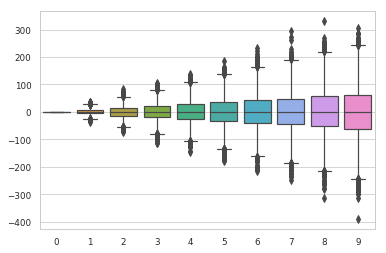

[17:21:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


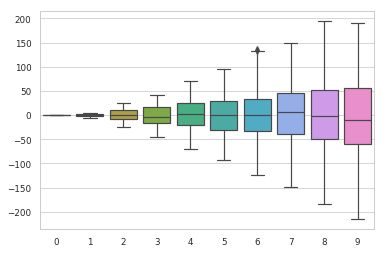

[17:21:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

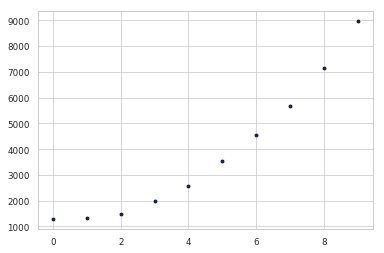

In [39]:
x, y, fi = test_data(10000)
sns.boxplot(data=fi)

plt.show()

model = xgboost.XGBRegressor(gbtree='gbtree')
fitted_model, score_before = train_and_evaluate_model(model, x, y, mse)

shap_coeffs, explainer, shap_values = calculate_tree_shap_coeffs(fitted_model, x)
sns.boxplot(data=shap_values)
plt.show()

scores = []
for i in range(10):
    new_x = deepcopy(x)
    new_x[:,i] = new_x[:,i].mean()
    fitted_model, new_score = train_and_evaluate_model(model, new_x, y, mse)
    scores.append(new_score)
sns.scatterplot(range(10),scores)